In [1]:
import pymania as mn
import pylab as plt

In [2]:
subs = [126426, 137431, 144125, 146735, 152427, 153227, 177140, 180533, 186545, 188145]
D = {1:('L87','L29',5,25,[186545, 180533, 137431, 153227, 126426]),
2:('L147','L49',5,25,[146735, 144125, 137431, 177140, 153227]),
3:('L2','L107',5,25,[152427, 188145, 146735, 186545, 137431]),
4:('L133','L88',5,25,[152427, 146735, 186545, 137431, 126426]),
5:('L140','L10',5,25,[152427, 188145, 144125, 177140, 153227]),
6:('L144','L27',5,25,[188145, 144125, 180533, 137431, 177140]),
7:('L97','L152',5,25,[188145, 146735, 186545, 177140, 126426]),
8:('L18','L149',5,25,[152427, 144125, 180533, 177140, 153227]),
9:('L128','L106',5,25,[188145, 146735, 144125, 177140, 126426]),
10:('L46','L77',5,25,[146735, 186545, 180533, 137431, 126426])}

In [3]:
def plot_conn(c):
    # c = 10 # connection num
    fig, ax  = plt.subplots(5,2,figsize=(15,20))
    for i,sub in enumerate(subs):
        a = mn.ST(subs[i],D[c][0],D[c][1])
        if sub in D[c][-1]:
            ax[(i)//2,i%2].set_facecolor('#DDFACB')
        else:
            ax[(i)//2,i%2].set_facecolor('#FCC1C0')
        try:
            a.process()
        except:
            pass
        a.plot(ax[(i)//2,i%2])
        if a.isNull():
            ax[(i)//2,i%2].set_facecolor('#000000')
            ax[(i)//2,i%2].text(0.05,.9,f'SUB:{subs[i]}',color="white")
        else:
            ax[(i)//2,i%2].text(0,-1,f'SUB:{subs[i]}',color="black")
    plt.tight_layout()
    plt.show()

/net/ht140/manoj/Softwares/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/net/ht140/manoj/Softwares/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


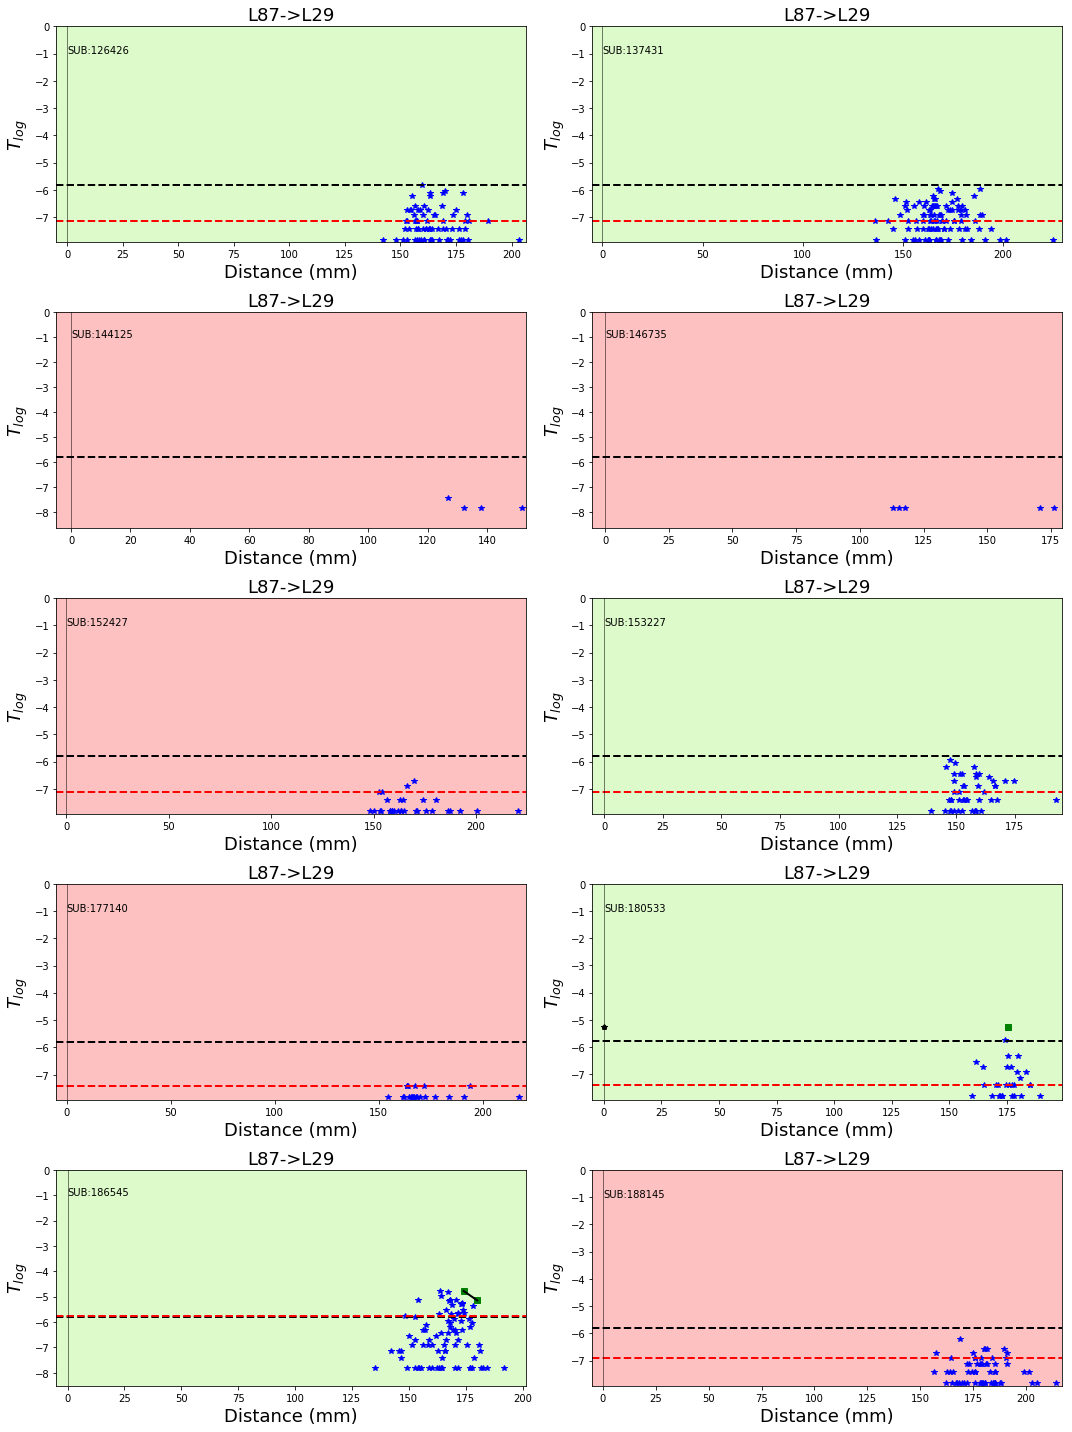

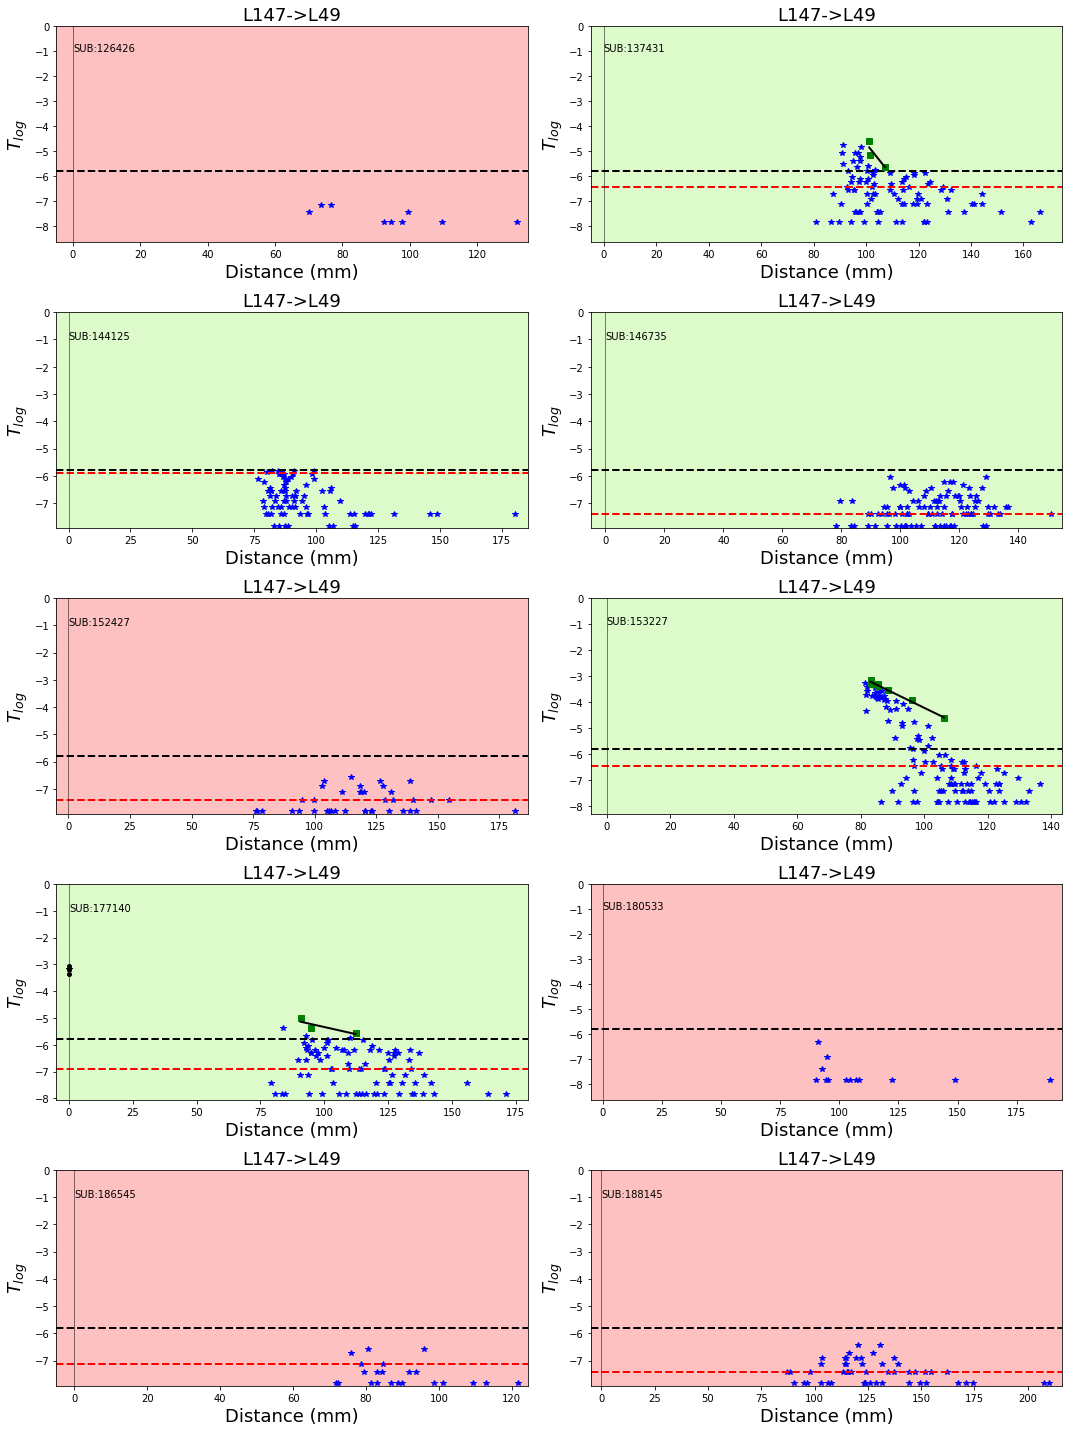




Connection L2 to L107 is null


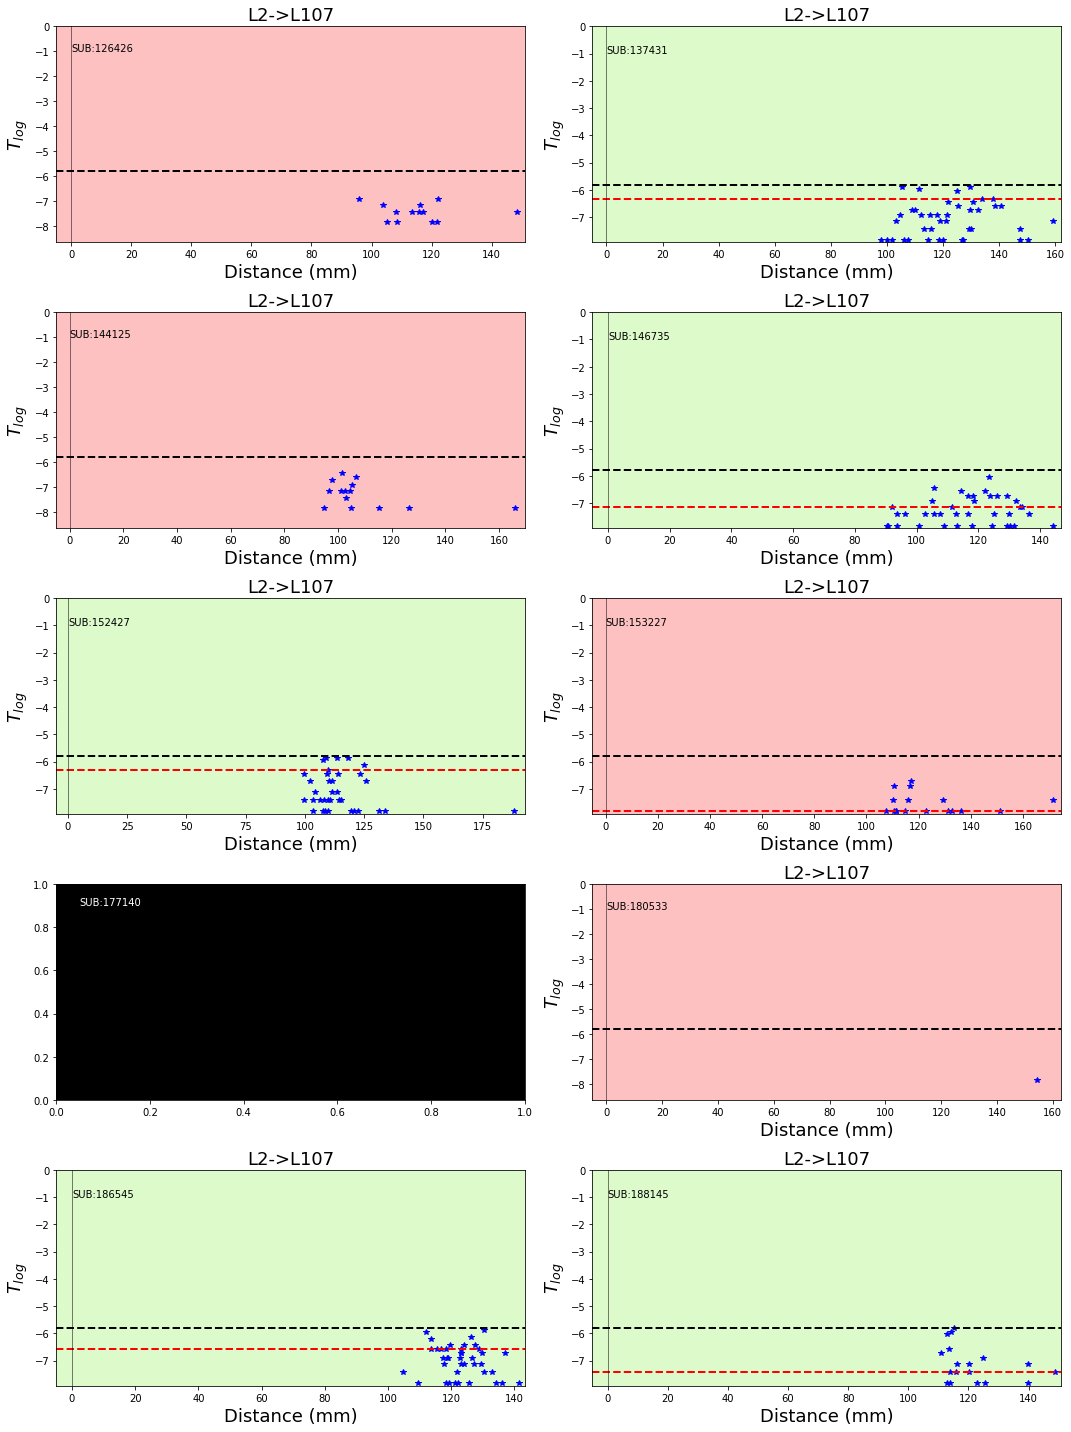

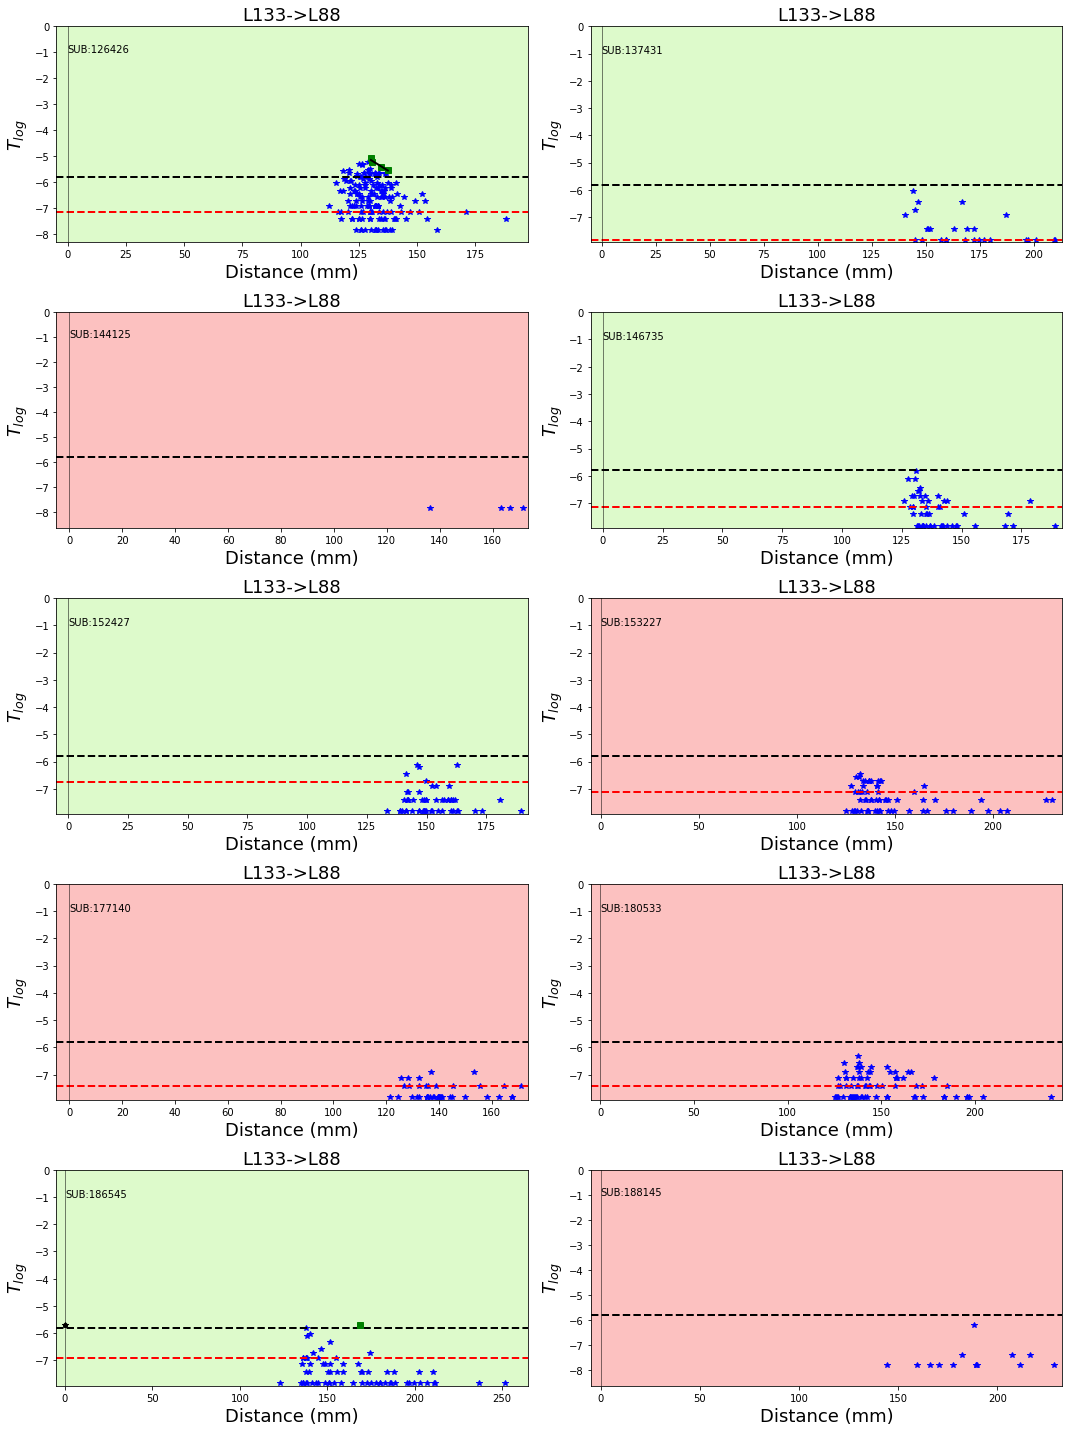




Connection L140 to L10 is null


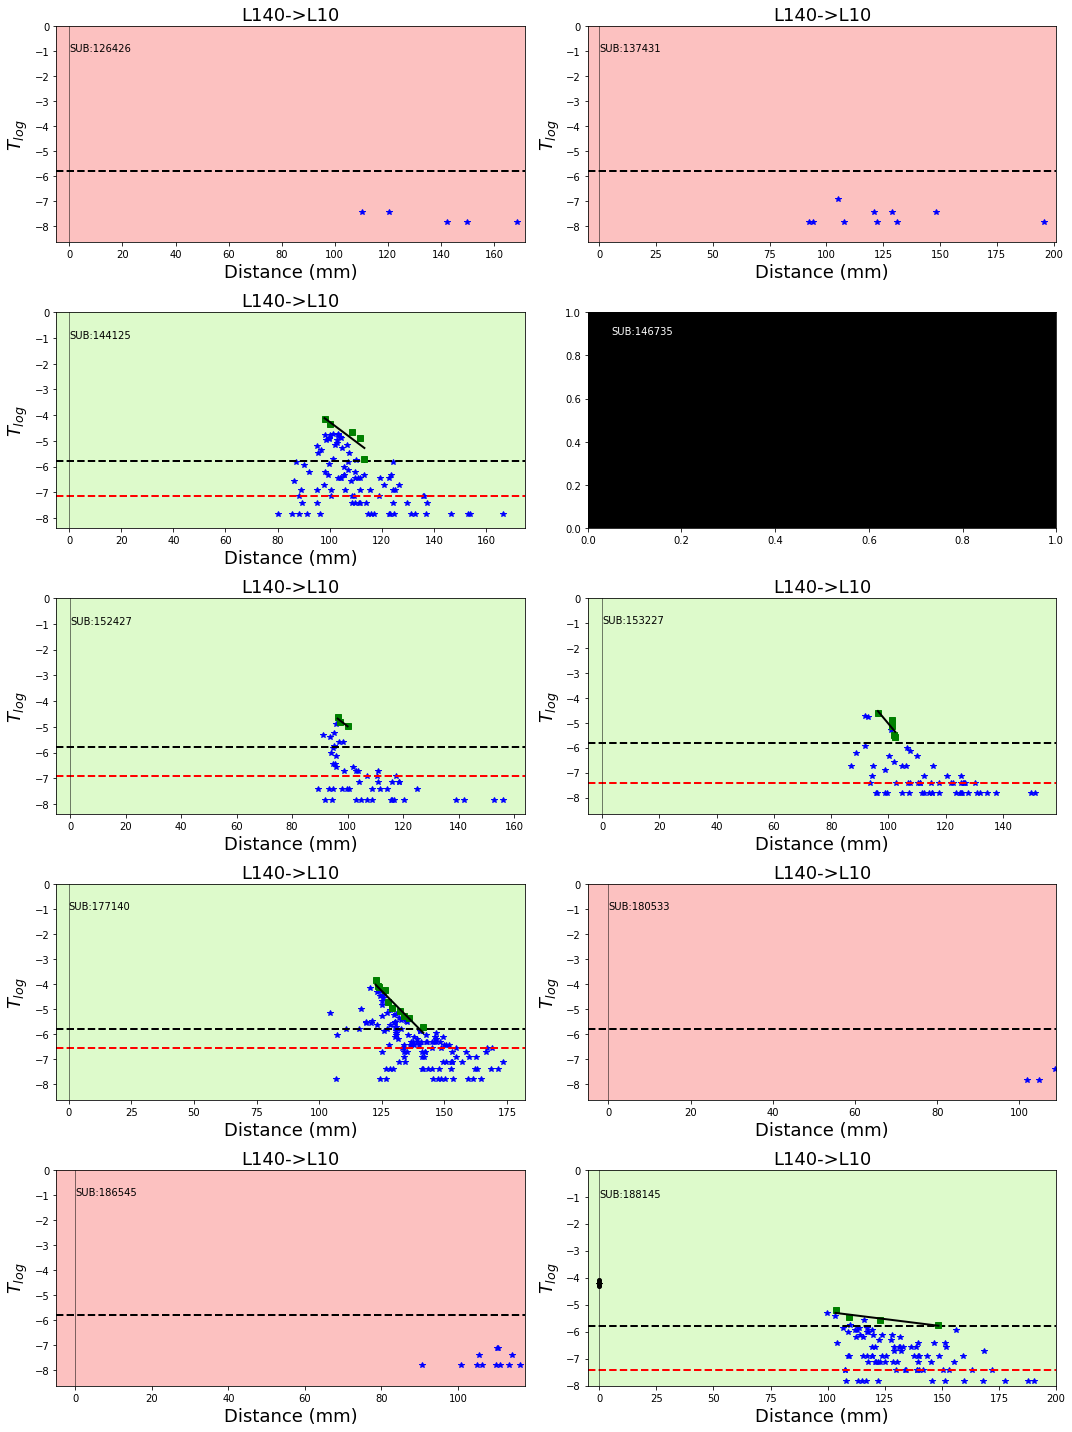




Connection L144 to L27 is null


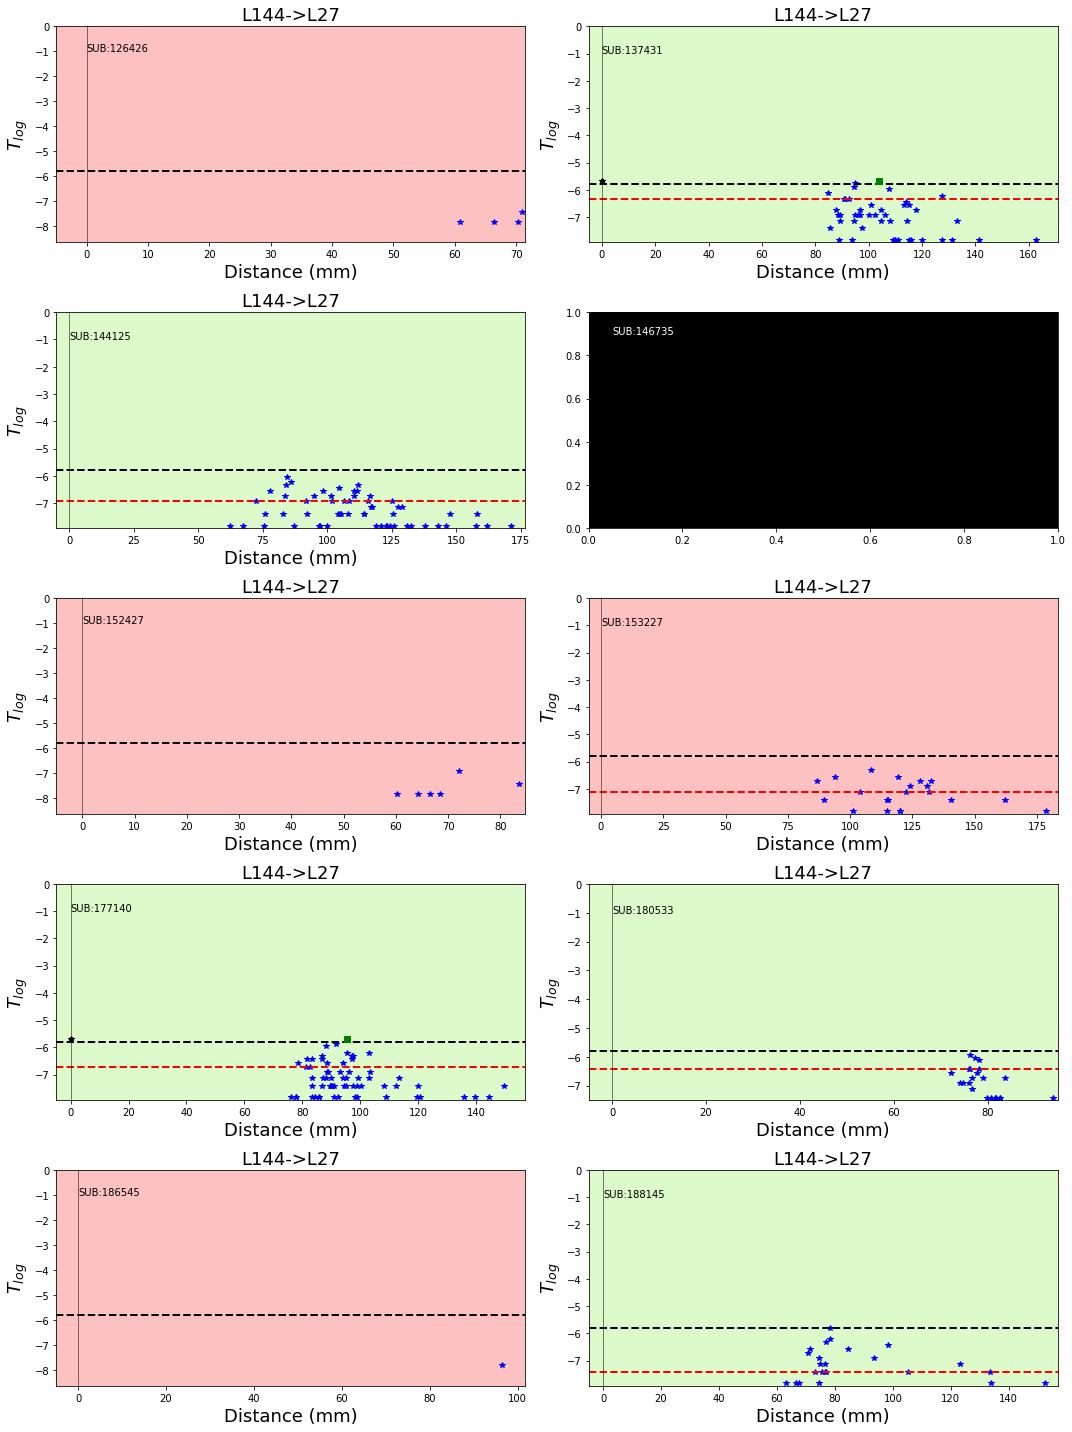




Connection L97 to L152 is null
Connection L97 to L152 is null
Connection L97 to L152 is null


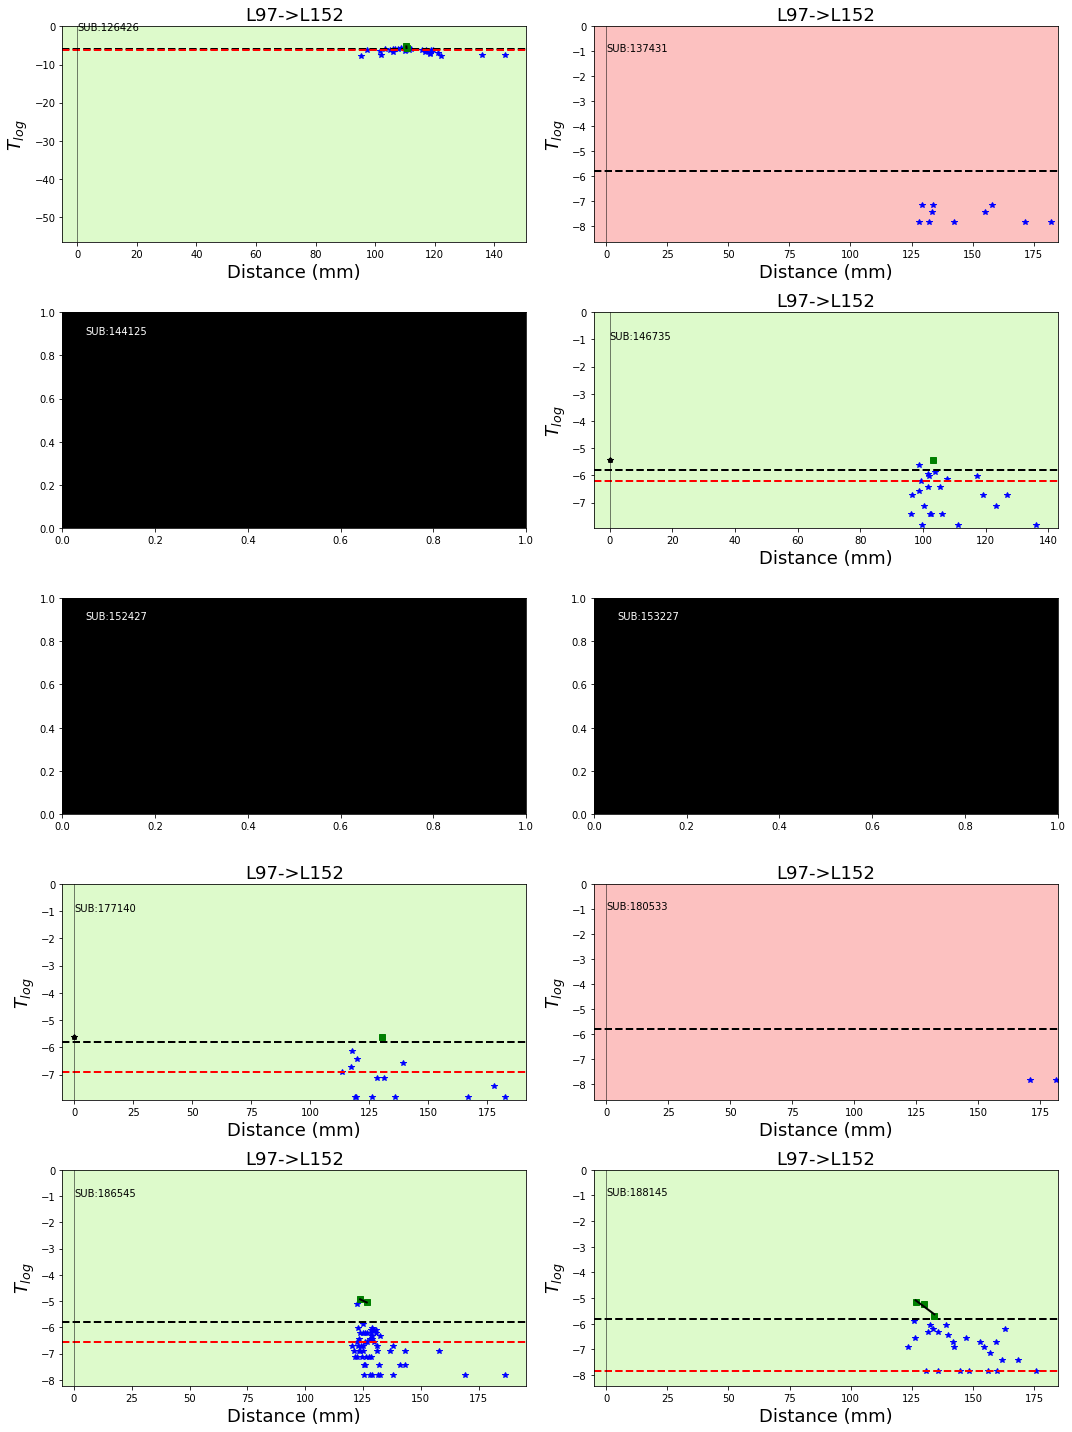




Connection L18 to L149 is null


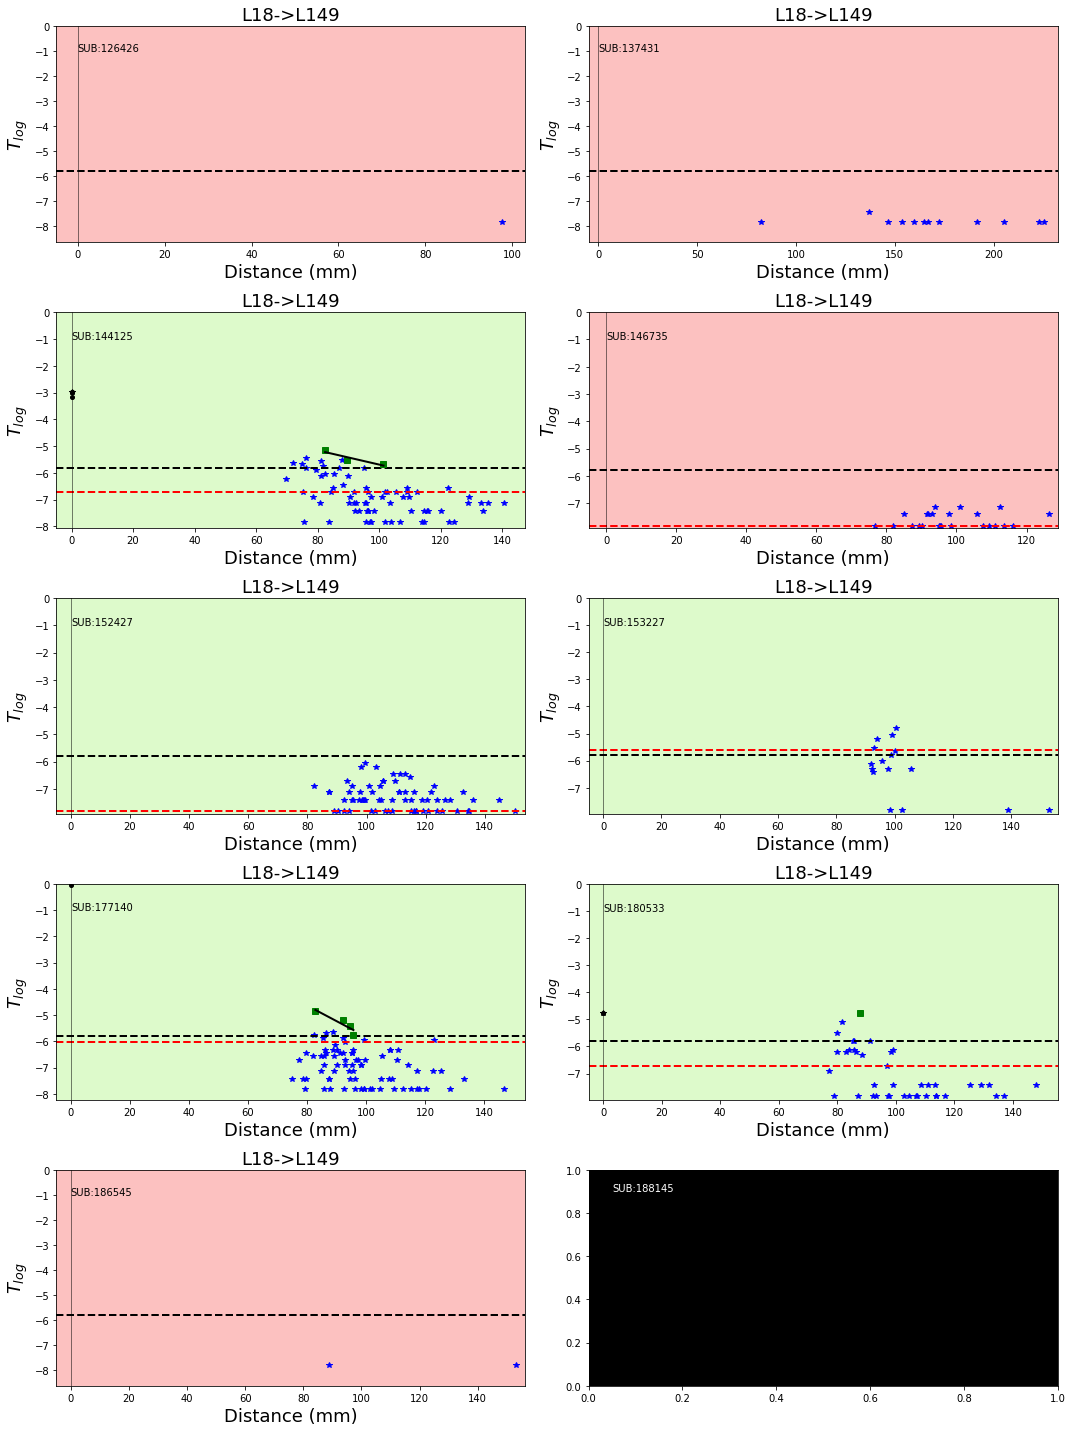

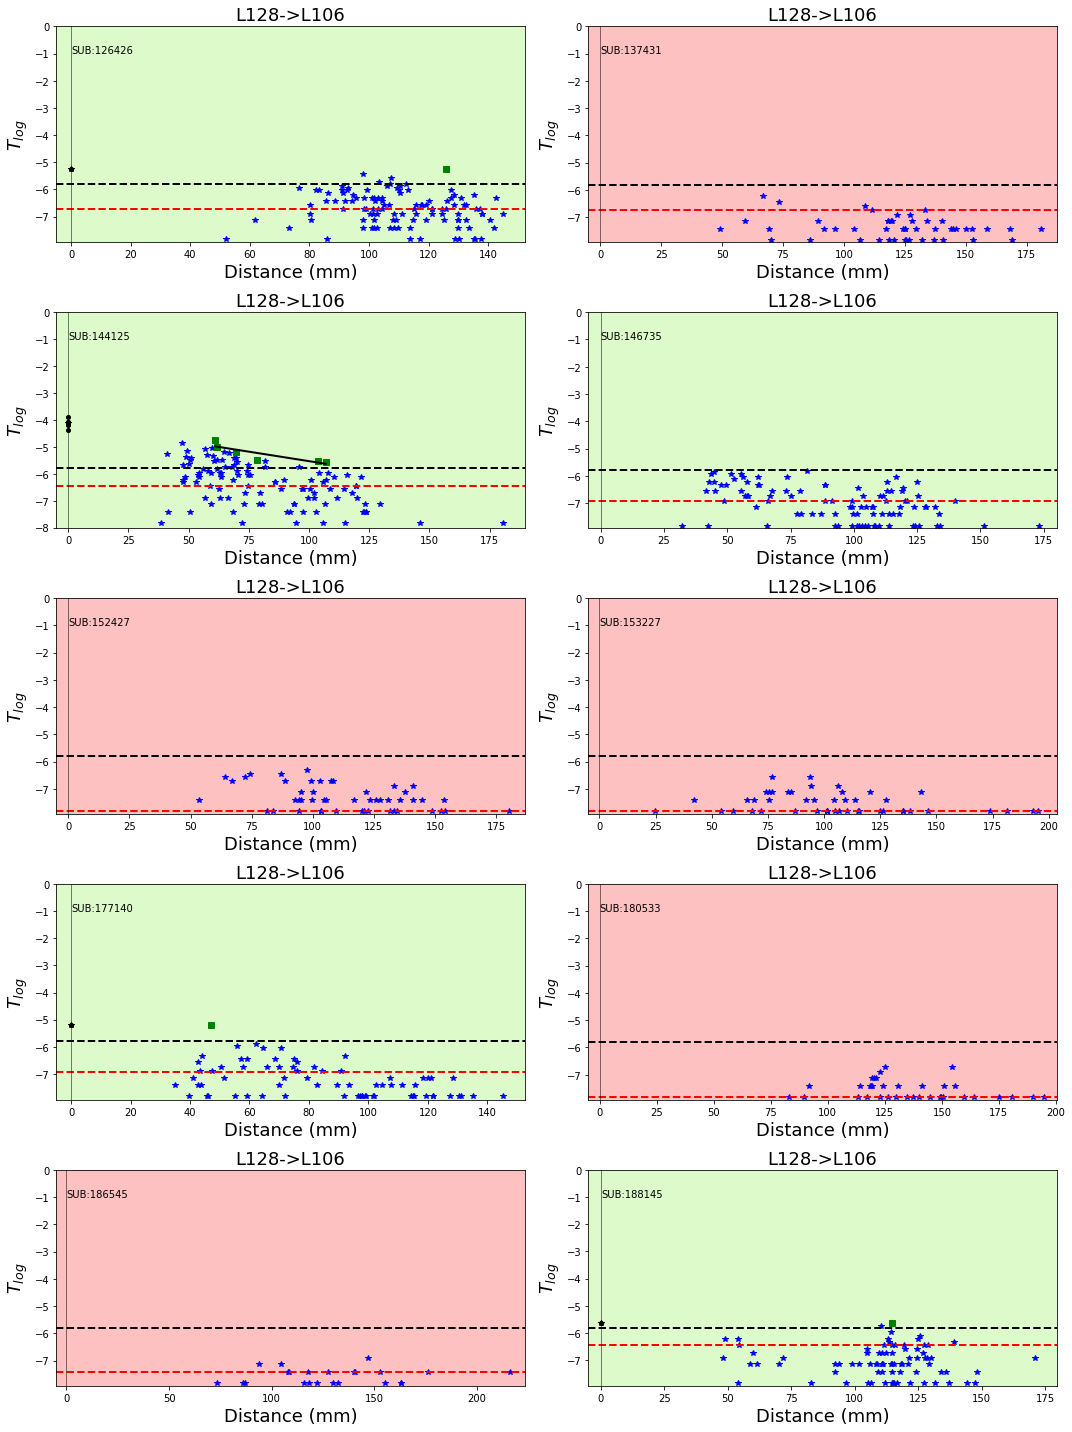

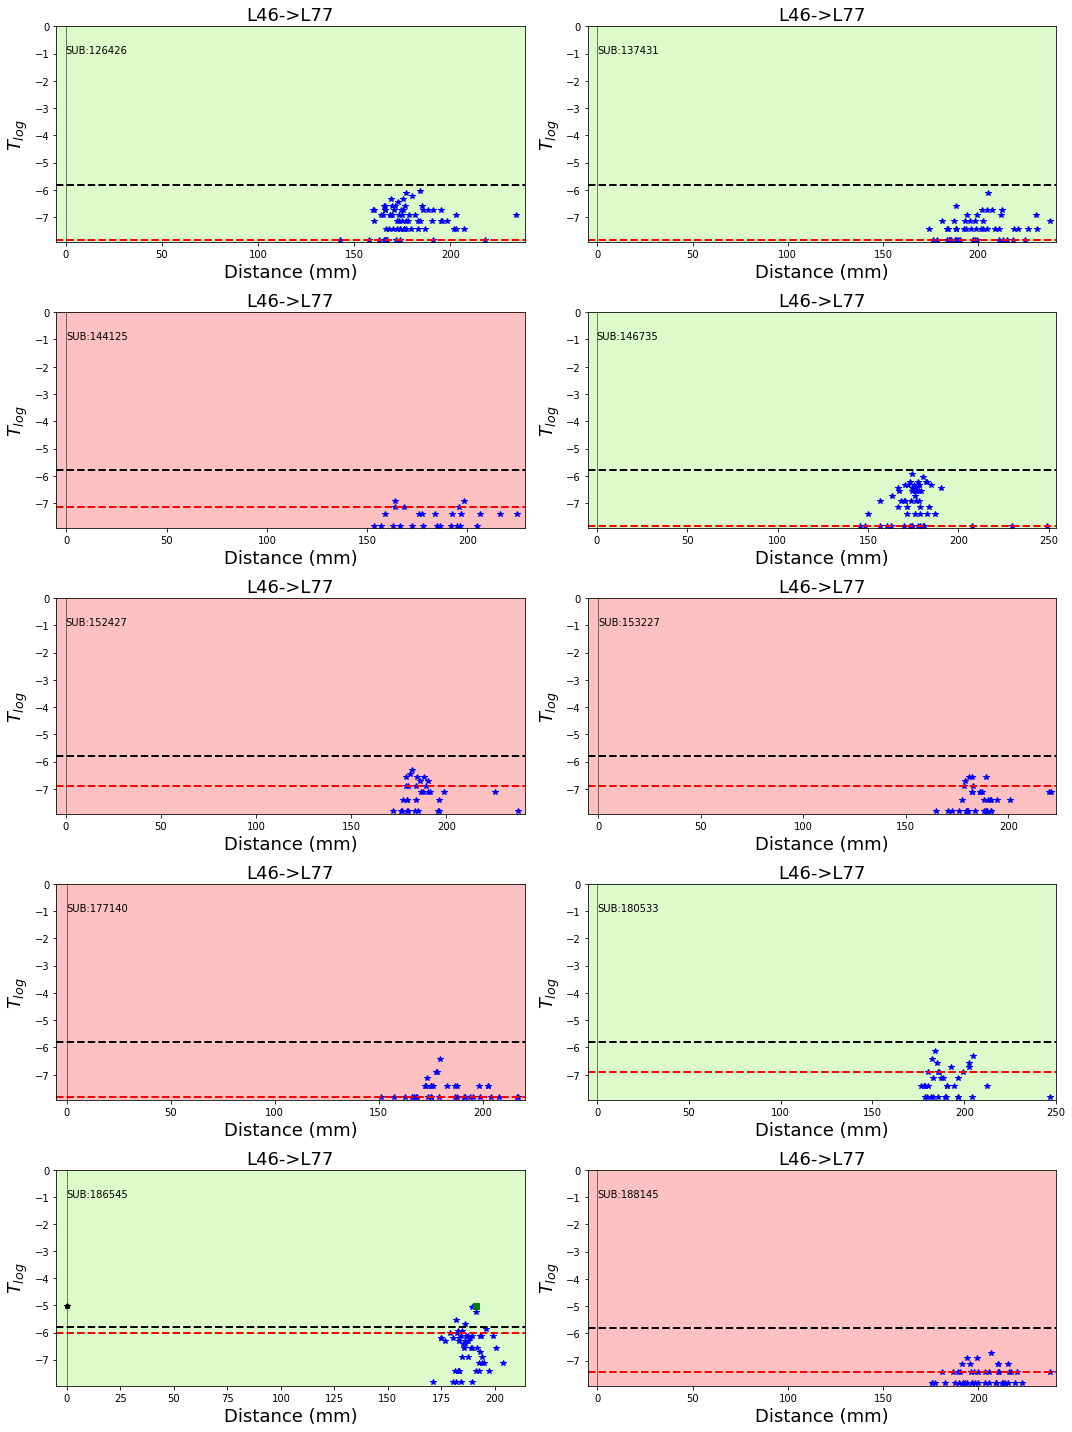

In [5]:
for i in range(1, 11):
    plot_conn(i)
    print('\n\n')